In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from game_of_life import next_frame, random_state

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'1.13.1'

In [3]:
class Input:
    W, H = 30, 30

    def generator(self):
        state = random_state(self.W, self.H)
        SEQ_LEN = 150
        current_seq_idx = 0

        while True:
            current_seq_idx += 1
            if current_seq_idx > SEQ_LEN:
                current_seq_idx = 0
                state = random_state(self.W, self.H)

            inp = np.expand_dims(state, -1)
            out = np.expand_dims(next_frame(state), -1)

            yield inp, out

    def as_dataset(self, batch_size):
        shapes =(tf.TensorShape([self.W, self.H, 1]), tf.TensorShape([self.W, self.H, 1]))
        dataset = tf.data.Dataset.from_generator(
            self.generator,
            (tf.int32,) * 2,
            shapes
        )

        dataset = dataset.shuffle(1024).batch(batch_size).repeat()

        return dataset

In [4]:
Input().as_dataset(32)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


<DatasetV1Adapter shapes: ((?, 30, 30, 1), (?, 30, 30, 1)), types: (tf.int32, tf.int32)>

In [184]:
def mk_model():
    inp = tf.keras.layers.Input(shape=(Input.W, Input.H, 1))
    x = inp
    x = tf.keras.layers.Conv2D(50, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(20, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(x)
#     x = tf.keras.layers.Conv2D(50, kernel_size=5, activation='relu')(x)
#     x = tf.keras.layers.Conv2DTranspose(50, kernel_size=5, activation='relu')(x)
#     x = tf.keras.layers.Conv2DTranspose(10, kernel_size=3, activation='sigmoid')(x)
#     x = tf.keras.layers.Conv2DTranspose(1, kernel_size=1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, x)
    
    model.compile(  
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


model = mk_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 30, 30, 50)        500       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 30, 20)        9020      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 30, 1)         21        
Total params: 9,541
Trainable params: 9,541
Non-trainable params: 0
_________________________________________________________________


In [226]:
model.fit(
    Input().as_dataset(512), steps_per_epoch=10,
    epochs=5
)

Epoch 1/5
10/10 [==============================] - 43s 4s/step - loss: 39.8383 - acc: 0.9961
Epoch 2/5
10/10 [==============================] - 44s 4s/step - loss: 41.3165 - acc: 0.9965
Epoch 3/5
10/10 [==============================] - 42s 4s/step - loss: 38.7296 - acc: 0.9965
Epoch 4/5
10/10 [==============================] - 40s 4s/step - loss: 39.8495 - acc: 0.9973
Epoch 5/5
10/10 [==============================] - 41s 4s/step - loss: 39.1476 - acc: 0.9978


In [228]:
inp = random_state(Input.W, Input.H)
out = next_frame(inp)

In [229]:
pred = np.squeeze(model.predict(inp.reshape((1, Input.W, Input.H, 1))))

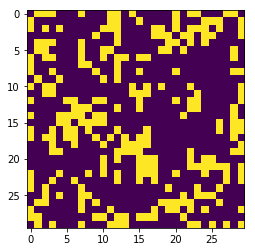

In [230]:
# Expected
plt.imshow(out)

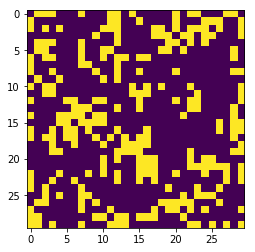

In [231]:
# Actua
plt.imshow(pred > 0.5)

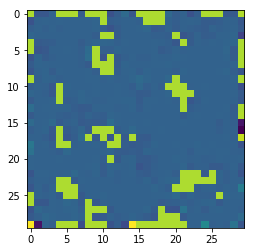

In [232]:
# Diff
plt.imshow(pred - out)

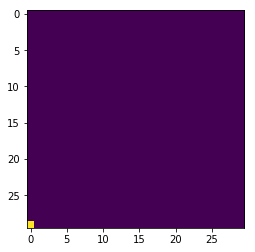

In [233]:
# Diff
plt.imshow((pred > 0.5) - out)

In [234]:
model.save(f'conway_{Input.W}x{Input.H}_small_error.h5')

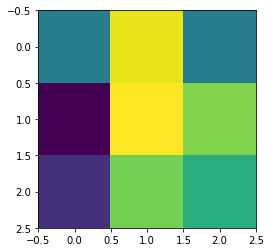

In [218]:
plt.imshow(np.squeeze(model.layers[1].get_weights()[0])[:,:,5])